In [124]:
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
from skimage import io
from skimage.color import rgb2gray
import pandas as pd
from scipy.spatial.distance import euclidean
from skimage.filters import threshold_otsu
from skimage.measure import label, regionprops
from skimage.morphology import convex_hull_image, remove_small_objects 
from scipy.ndimage import binary_fill_holes
import os
from sklearn.cluster import KMeans, DBSCAN
from sklearn.preprocessing import StandardScaler
from skimage.transform import resize
from sklearn.metrics import silhouette_score
# from skimage.io import imread, imsave

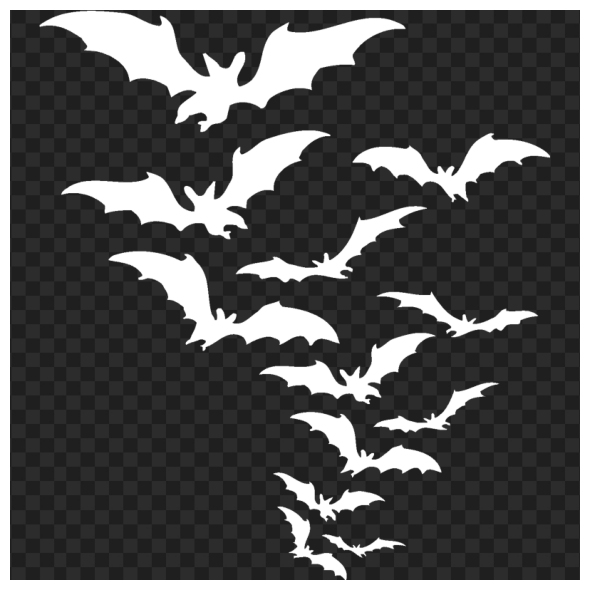

In [125]:
# Carregar a imagem
# imagem_original_preenchida = io.imread('imagem_1_2.jpeg')
imagem_original_preenchida = io.imread('test.png')

# Criar a imagem binarizada diretamente
# imagem_original_preenchida = np.where(imagem_original_preenchida > 20, 1, 0)


# Verificar se a imagem tem 4 canais (RGBA) e converter para RGB
if imagem_original_preenchida.shape[-1] == 4:
    imagem_original_preenchida = imagem_original_preenchida[:, :, :3]


# Mostrar os resultados
plt.figure(figsize=(12, 6))

plt.subplot(1, 1, 1)
plt.imshow(imagem_original_preenchida, cmap='gray')
# plt.title("Imagem Preenchida")
plt.axis("off")

plt.tight_layout()
plt.show()

In [126]:
# Converter para escala de cinza
imagem_cinza = rgb2gray(imagem_original_preenchida)

# Binarizar a imagem usando o método Otsu
limiar = threshold_otsu(imagem_cinza)
imagem_binaria = imagem_cinza > limiar

# Remover ruídos pequenos
imagem_limpa = remove_small_objects(imagem_binaria, min_size=100)

# Rotular os componentes conexos
rotulos, num_componentes = label(imagem_limpa, connectivity=2, return_num=True)

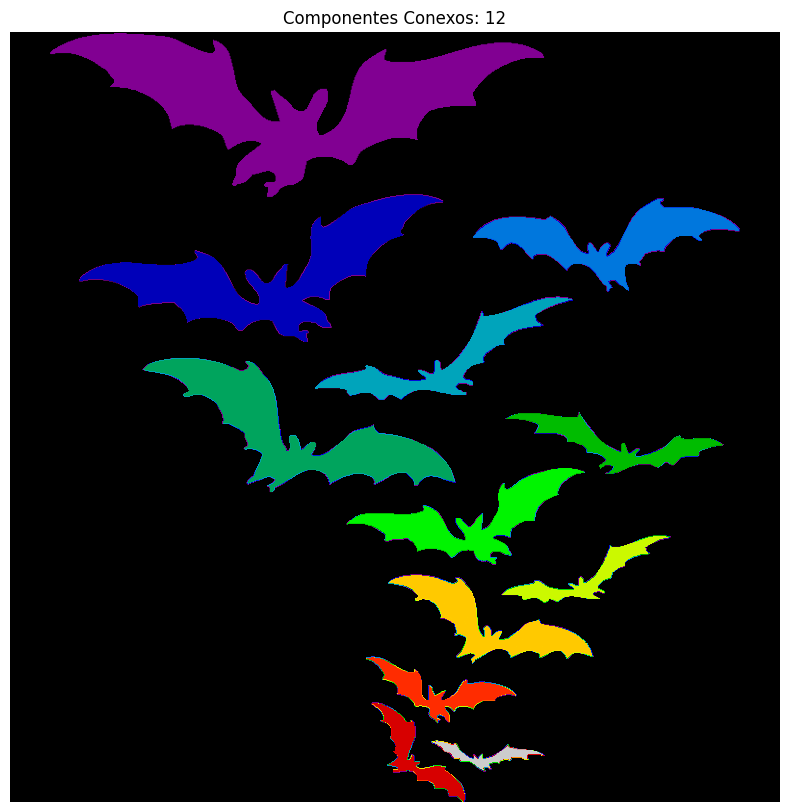

Número de componentes conexos: 12


In [127]:
# Mostrar a imagem rotulada
plt.figure(figsize=(10, 10))
plt.title(f'Componentes Conexos: {num_componentes}')
plt.imshow(rotulos, cmap='nipy_spectral')
plt.axis('off')
plt.show()

print(f"Número de componentes conexos: {num_componentes}")


12 componentes separados e salvos na pasta 'componentes_conexos'.


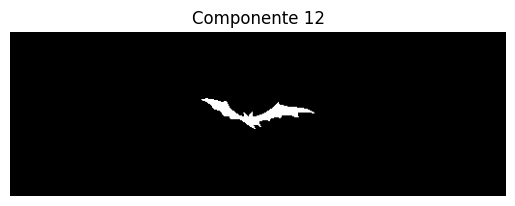

In [128]:
# Criar pasta para salvar os componentes
output_folder = "componentes_conexos"
os.makedirs(output_folder, exist_ok=True)

# Variáveis para armazenar o tamanho máximo
max_height, max_width = 0, 0

# Encontrar as dimensões máximas
for region in regionprops(rotulos):
    minr, minc, maxr, maxc = region.bbox
    height, width = maxr - minr, maxc - minc
    max_height = max(max_height, height)
    max_width = max(max_width, width)

# Criar e salvar uma imagem para cada componente, redimensionando
for region in regionprops(rotulos):
    # Pegar coordenadas do bounding box do componente
    minr, minc, maxr, maxc = region.bbox

    # Extrair o componente da imagem original
    componente = (rotulos[minr:maxr, minc:maxc] == region.label).astype(np.uint8)

    # Criar uma nova imagem com tamanho máximo e preencher com o componente
    padded_componente = np.zeros((max_height, max_width), dtype=np.uint8)
    start_row = (max_height - componente.shape[0]) // 2
    start_col = (max_width - componente.shape[1]) // 2
    padded_componente[start_row:start_row + componente.shape[0], start_col:start_col + componente.shape[1]] = componente

    # Salvar a imagem do componente
    io.imsave(os.path.join(output_folder, f"componente_{region.label}.png"), padded_componente * 255)

    # Mostrar o componente
    plt.imshow(padded_componente, cmap="gray")
    plt.title(f"Componente {region.label}")
    plt.axis("off")
    # plt.show()

print(f"{len(regionprops(rotulos))} componentes separados e salvos na pasta '{output_folder}'.")



In [129]:
num_componentes

12

In [ ]:
# Criar componentes padronizados e calcular descritores
components = []
max_height, max_width = 0, 0

# Encontrar o maior tamanho
for region in regionprops(rotulos):
    minr, minc, maxr, maxc = region.bbox
    height, width = maxr - minr, maxc - minc
    max_height = max(max_height, height)
    max_width = max(max_width, width)

# Criar componentes ajustados
for region in regionprops(rotulos):
    minr, minc, maxr, maxc = region.bbox
    component = (rotulos[minr:maxr, minc:maxc] == region.label).astype(np.uint8)

    padded_component = np.zeros((max_height, max_width), dtype=np.uint8)
    start_row = (max_height - component.shape[0]) // 2
    start_col = (max_width - component.shape[1]) // 2
    padded_component[start_row:start_row + component.shape[0], start_col:start_col + component.shape[1]] = component

    components.append(padded_component)

descriptors = calculate_descriptors(components)

# Exibir imagem e descritores lado a lado
for i, (component, desc) in enumerate(zip(components, descriptors)):
    plt.figure(figsize=(10, 5))

    # Imagem do componente
    plt.subplot(1, 2, 1)
    plt.imshow(component, cmap="gray")
    plt.title(f"Componente {i + 1}")
    plt.axis("off")

    # Dados dos descritores
    plt.subplot(1, 2, 2)
    desc_text = "\n".join([f"{key}: {value:.2f}" for key, value in desc.items()])
    plt.text(0.1, 0.5, desc_text, fontsize=12, va="center", ha="left")
    plt.axis("off")
    plt.title("Descritores")

    plt.tight_layout()
    plt.show()


In [131]:
# Inicializar os vetores
descritores_completos = descriptors  # Vetor contendo todos os descritores
descritores_adimensionais = []  # Vetor contendo apenas os descritores adimensionais

# Preencher o vetor de descritores adimensionais
for componente in descritores_completos:
    descritores_adimensionais.append({
        "Compacidade": componente['Compacidade'],
        "Quociente Isoperimétrico": componente['Quociente Isoperimétrico'],
        "Excentricidade": componente['Excentricidade'],
        "Convexidade": componente['Convexidade'],
        "Retangularidade": componente['Retangularidade'],
        "Solidez": componente['Solidez']
    })

# Agora, descritores_completos contém todos os descritores e descritores_adimensionais contém apenas os adimensionais
print("Vetor de todos os descritores (descritores_completos):", descritores_completos)
print("Vetor de descritores adimensionais (descritores_adimensionais):", descritores_adimensionais)


Vetor de todos os descritores (descritores_completos): [{'Área': np.float64(29525.0), 'Perímetro': np.float64(1651.1128778409575), 'Compacidade': np.float64(7.347739639488399), 'Quociente Isoperimétrico': np.float64(0.13609627573434638), 'Eixo Maior': 481.9718110321226, 'Eixo Menor': 149.21031725651235, 'Excentricidade': 0.9508723979531614, 'Convexidade': np.float64(1.7402540220152414), 'Retangularidade': np.float64(0.41055317397295304), 'Solidez': np.float64(0.5746287538195053)}, {'Área': np.float64(16824.0), 'Perímetro': np.float64(1240.7859300126263), 'Compacidade': np.float64(7.282065761086297), 'Quociente Isoperimétrico': np.float64(0.1373236706188198), 'Eixo Maior': 363.2357722901162, 'Eixo Menor': 113.30676611079186, 'Excentricidade': 0.9501027076860307, 'Convexidade': np.float64(1.7510104612458393), 'Retangularidade': np.float64(0.40877544772576546), 'Solidez': np.float64(0.571098815302624)}, {'Área': np.float64(8683.0), 'Perímetro': np.float64(815.8498551495554), 'Compacidade'

In [132]:
# Função para extrair apenas os valores numéricos dos descritores
def extrair_valores_numericos(componente):
    return [
        componente["Área"],
        componente["Perímetro"],
        componente["Compacidade"],
        componente["Quociente Isoperimétrico"],
        componente["Eixo Maior"],
        componente["Eixo Menor"],
        componente["Excentricidade"],
        componente["Convexidade"],
        componente["Retangularidade"],
        componente["Solidez"]
    ]

# Número de componentes (suponha que você tenha 10 componentes)
n = len(descriptors)  # Isso deve ser 10

# Inicializar a matriz de distâncias
distancia_matriz = np.zeros((n, n))

# Preencher a matriz de distâncias
for i in range(n):
    for j in range(i, n):  # Apenas preencher a metade superior, pois a matriz é simétrica
        # Extrair os valores numéricos dos descritores
        descritor_i = extrair_valores_numericos(descriptors[i])
        descritor_j = extrair_valores_numericos(descriptors[j])
        
        # Calcular a distância Euclidiana entre os descritores
        dist = euclidean(descritor_i, descritor_j)
        
        # Preencher a matriz simétrica
        distancia_matriz[i, j] = dist
        distancia_matriz[j, i] = dist  # Matriz simétrica

# Gerar os nomes para as linhas e colunas com base nas chaves dos descritores
nomes_colunas = [f"Componente_{i+1}" for i in range(n)]  # Usando um nome genérico para as componentes

# Criar um DataFrame a partir da matriz de distâncias com nomes de colunas e linhas
data = pd.DataFrame(distancia_matriz, columns=nomes_colunas, index=nomes_colunas)

# Exibir o DataFrame
data


,Componente_1,Componente_2,Componente_3,Componente_4,Componente_5,Componente_6,Componente_7,Componente_8,Componente_9,Componente_10,Componente_11,Componente_12
Componente_1,0.000000,12708.231841,20859.923091,23568.132956,15901.290637,25729.654651,22360.534055,27001.634929,23713.617374,26615.881628,27173.939990,28526.390835
Componente_2,12708.231841,0.000000,8152.690062,10860.225281,3194.149603,13022.305517,9652.808851,14294.789873,11006.494627,13909.177891,14468.045867,15820.872303
Componente_3,20859.923091,8152.690062,0.000000,2709.281457,4958.795471,4869.752138,1501.459058,6142.119150,2853.864397,5756.653265,6315.831167,7668.766659
Componente_4,23568.132956,10860.225281,2709.281457,0.000000,7666.880009,2163.629944,1209.095799,3437.272353,184.432115,3053.059117,3614.296358,4966.610075
Componente_5,15901.290637,3194.149603,4958.795471,7666.880009,0.000000,9828.512215,6459.347501,11100.860416,7812.636363,10715.297231,11274.054146,12626.856661
Componente_6,25729.654651,13022.305517,4869.752138,2163.629944,9828.512215,0.000000,3369.840827,1273.695560,2016.245414,890.858174,1452.740339,2803.582334
Componente_7,22360.534055,9652.808851,1501.459058,1209.095799,6459.347501,3369.840827,0.000000,4642.708726,1355.094478,4257.343829,4817.580749,6170.556075
Componente_8,27001.634929,14294.789873,6142.119150,3437.272353,11100.860416,1273.695560,4642.708726,0.000000,3288.322669,387.551051,195.589214,1530.383960
Componente_9,23713.617374,11006.494627,2853.864397,184.432115,7812.636363,2016.245414,1355.094478,3288.322669,0.000000,2902.890421,3462.686080,4815.658531
Componente_10,26615.881628,13909.177891,5756.653265,3053.059117,10715.297231,890.858174,4257.343829,387.551051,2902.890421,0.000000,563.188594,1914.061516


In [133]:
# Função para extrair apenas os valores numéricos dos descritores
def extrair_valores_numericos(componente):
    return [     
        componente["Compacidade"],
        componente["Quociente Isoperimétrico"],
        componente["Excentricidade"],
        componente["Convexidade"],
        componente["Retangularidade"],
        componente["Solidez"]
    ]
# Número de componentes (suponha que você tenha 10 componentes)
n = len(descritores_adimensionais)  # Isso deve ser 10

# Inicializar a matriz de distâncias
distancia_matriz_VA = np.zeros((n, n))

# Preencher a matriz de distâncias
for i in range(n):
    for j in range(i, n):  # Apenas preencher a metade superior, pois a matriz é simétrica
        # Extrair os valores numéricos dos descritores
        descritor_i = extrair_valores_numericos(descritores_adimensionais[i])
        descritor_j = extrair_valores_numericos(descritores_adimensionais[j])
        
        # Calcular a distância Euclidiana entre os descritores
        dist = euclidean(descritor_i, descritor_j)
        
        # Preencher a matriz simétrica
        distancia_matriz_VA[i, j] = dist
        distancia_matriz_VA[j, i] = dist  # Matriz simétrica

# Gerar os nomes para as linhas e colunas com base nas chaves dos descritores
nomes_colunas = [f"Componente_{i+1}" for i in range(n)]  # Usando um nome genérico para as componentes

# Criar um DataFrame a partir da matriz de distâncias com nomes de colunas e linhas
data_va = pd.DataFrame(distancia_matriz_VA, columns=nomes_colunas, index=nomes_colunas)

# Exibir o DataFrame
data_va


,Componente_1,Componente_2,Componente_3,Componente_4,Componente_5,Componente_6,Componente_7,Componente_8,Componente_9,Componente_10,Componente_11,Componente_12
Componente_1,0.000000,0.066682,1.251928,0.839795,0.974230,0.492712,0.195513,0.448392,1.101870,0.409309,1.842178,0.349272
Componente_2,0.066682,0.000000,1.185673,0.894882,0.907909,0.532809,0.129470,0.486632,1.035558,0.343442,1.776238,0.307147
Componente_3,1.251928,1.185673,0.000000,2.023672,0.278469,1.611281,1.056663,1.564554,0.150696,0.843578,0.594201,1.073802
Componente_4,0.839795,0.894882,2.023672,0.000000,1.749036,0.415989,1.014999,0.461001,1.874373,1.217760,2.616342,0.953872
Componente_5,0.974230,0.907909,0.278469,1.749036,0.000000,1.338511,0.779172,1.291382,0.127868,0.566883,0.872089,0.803577
Componente_6,0.492712,0.532809,1.611281,0.415989,1.338511,0.000000,0.636879,0.048445,1.462739,0.824836,2.202805,0.539175
Componente_7,0.195513,0.129470,1.056663,1.014999,0.779172,0.636879,0.000000,0.589149,0.906703,0.213982,1.646875,0.278514
Componente_8,0.448392,0.486632,1.564554,0.461001,1.291382,0.048445,0.589149,0.000000,1.415833,0.776483,2.156399,0.493028
Componente_9,1.101870,1.035558,0.150696,1.874373,0.127868,1.462739,0.906703,1.415833,0.000000,0.694036,0.744709,0.926176
Componente_10,0.409309,0.343442,0.843578,1.217760,0.566883,0.824836,0.213982,0.776483,0.694036,0.000000,1.433016,0.351339


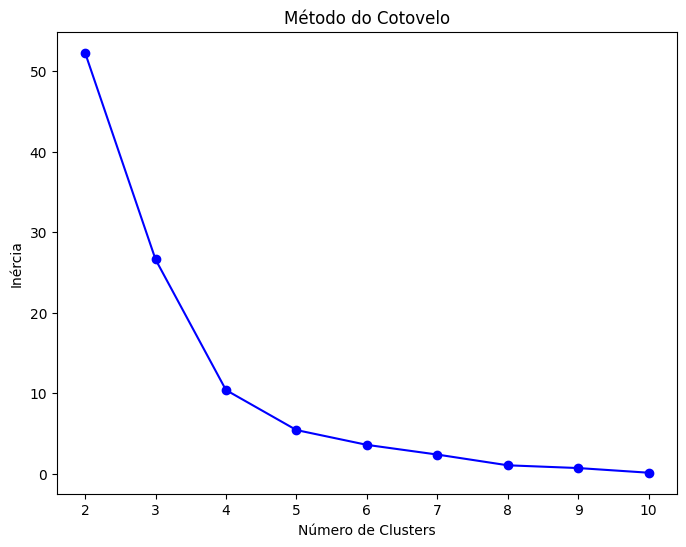

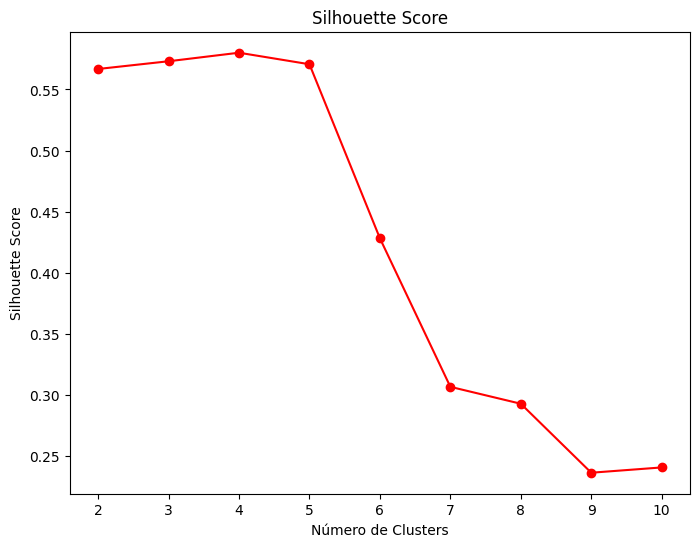

Número ideal de clusters (com maior Silhouette Score): 4
Componentes agrupados por cluster (KMeans):

Cluster 0: Componente_3, Componente_5, Componente_9
Cluster 1: Componente_1, Componente_2, Componente_7, Componente_10, Componente_12
Cluster 2: Componente_4, Componente_6, Componente_8
Cluster 3: Componente_11


In [134]:
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
import pandas as pd

# Normalizar os dados, caso ainda não tenha feito
scaler = StandardScaler()
data_va_scaled = scaler.fit_transform(data_va)

# Inicializando listas para armazenar inércia e Silhouette Score
inertia = []  
silhouette_scores = []

# Testando um intervalo de clusters de 2 até 10
for k in range(2, 11):
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(data_va_scaled)  # Usando os dados escalados
    inertia.append(kmeans.inertia_)
    silhouette_scores.append(silhouette_score(data_va_scaled, kmeans.labels_))

# Plotando o gráfico do Método do Cotovelo
plt.figure(figsize=(8, 6))
plt.plot(range(2, 11), inertia, marker='o', color='b', label='Inércia')
plt.xlabel('Número de Clusters')
plt.ylabel('Inércia')
plt.title('Método do Cotovelo')
plt.show()

# Plotando o gráfico do Silhouette Score
plt.figure(figsize=(8, 6))
plt.plot(range(2, 11), silhouette_scores, marker='o', color='r', label='Silhouette Score')
plt.xlabel('Número de Clusters')
plt.ylabel('Silhouette Score')
plt.title('Silhouette Score')
plt.show()

# Determinando o número ideal de clusters (usando o maior Silhouette Score)
optimal_k = silhouette_scores.index(max(silhouette_scores)) + 2  # +2 porque o range começa de 2
print(f'Número ideal de clusters (com maior Silhouette Score): {optimal_k}')

# Aplicando o KMeans com o número ideal de clusters
kmeans_optimal = KMeans(n_clusters=optimal_k, random_state=42)
kmeans_optimal.fit(data_va_scaled)

# Obtenha os rótulos do KMeans
labels = kmeans_optimal.labels_

# Criar o DataFrame com os componentes e seus respectivos clusters
# Supondo que 'data_va' tenha a mesma ordem de componentes que você deseja agrupar.
component_names = [f"Componente_{i+1}" for i in range(data_va.shape[0])]  # Ajuste se necessário

# Ajustando a estrutura do DataFrame
clusters_grouped = pd.DataFrame({
    'Componente': component_names,  # Nomes dos componentes
    'Cluster': labels
})

# Agrupar os componentes por cluster
clusters_grouped = clusters_grouped.groupby('Cluster')['Componente'].apply(list)

# Exibir os componentes agrupados por cluster
print("Componentes agrupados por cluster (KMeans):\n")
for cluster, componentes in clusters_grouped.items():
    print(f"Cluster {cluster}: {', '.join(map(str, componentes))}")


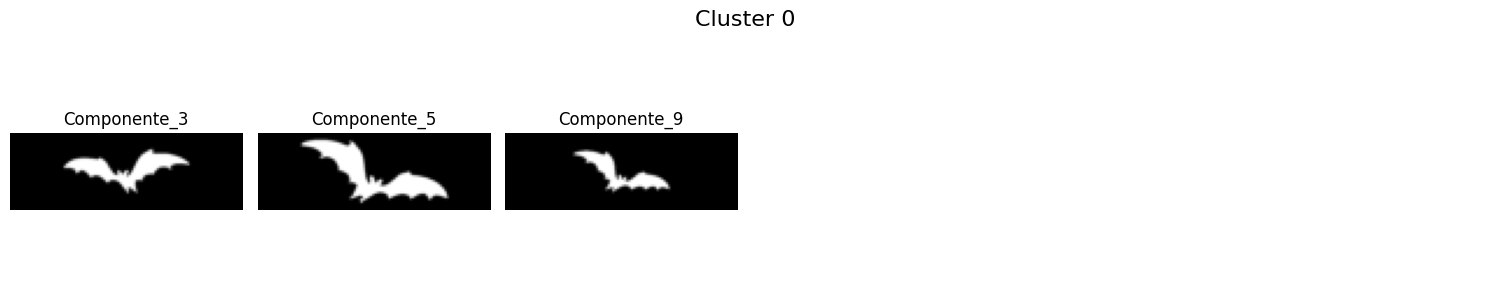

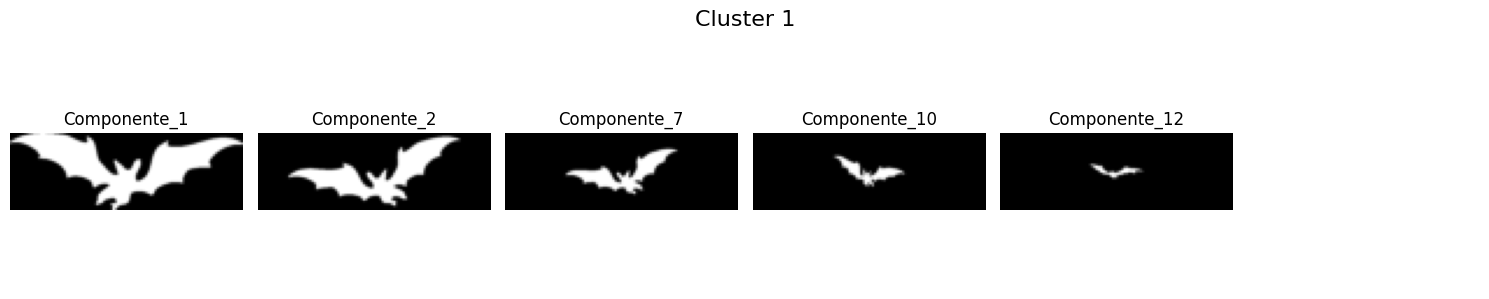

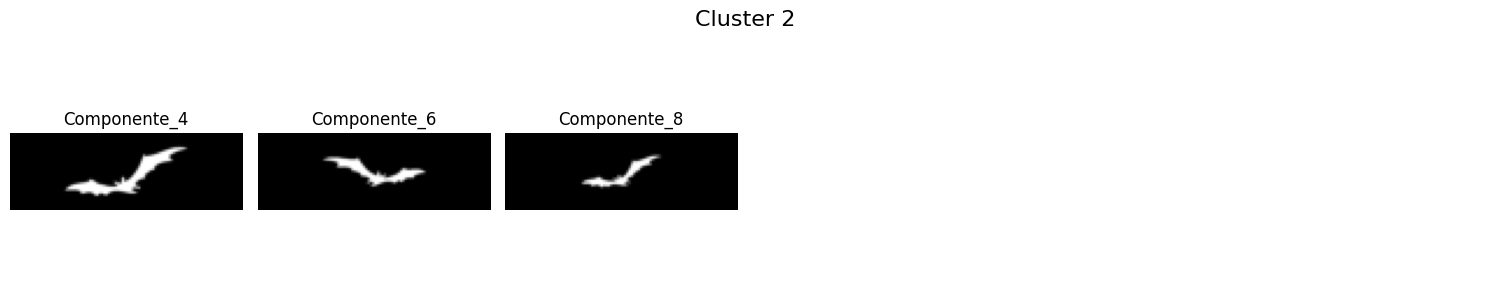

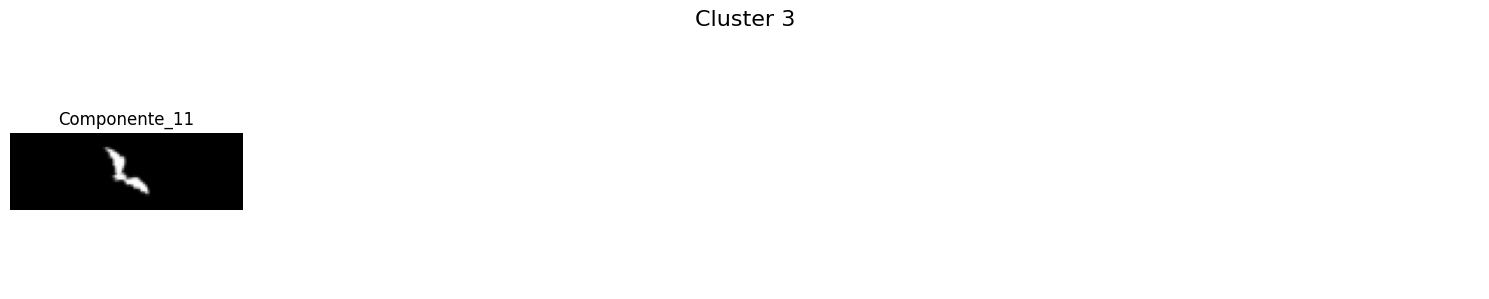

In [135]:


# Limite de 6 imagens por linha
images_per_row = 6

# Tamanho fixo máximo para as imagens (garante uniformidade sem cortar)
max_image_height = 100  # Altura máxima
max_image_width = 100   # Largura máxima

# Ajuste o layout de imagens, sem sobreposição
for cluster, componentes in clusters_grouped.items():
    num_components = len(componentes)
    
    # Calcular o número de linhas necessárias
    num_rows = (num_components // images_per_row) + (1 if num_components % images_per_row != 0 else 0)
    
    # Criar uma nova figura para cada cluster
    fig, axs = plt.subplots(num_rows, images_per_row, figsize=(images_per_row * 2.5, num_rows * 3))
    
    # Garantir que axs seja uma lista de listas para facilitar o acesso
    axs = axs.reshape(num_rows, images_per_row)
    
    # Preencher os subgráficos com as imagens dos componentes
    for i, comp_name in enumerate(componentes):
        comp_idx = int(comp_name.split('_')[1]) - 1  # Converter para índice (0-based)
        comp_image = components[comp_idx]
        
        # Redimensionar a imagem proporcionalmente, mantendo a relação de aspecto
        height, width = comp_image.shape
        aspect_ratio = width / height
        
        if width > height:
            new_width = max_image_width
            new_height = int(max_image_width / aspect_ratio)
        else:
            new_height = max_image_height
            new_width = int(max_image_height * aspect_ratio)
        
        comp_image_resized = resize(comp_image, (new_height, new_width), mode='reflect', anti_aliasing=True)
        
        row = i // images_per_row
        col = i % images_per_row
        
        axs[row, col].imshow(comp_image_resized, cmap="gray")
        axs[row, col].axis("off")
        axs[row, col].set_title(f"{comp_name}")
    
    # Desabilitar os subgráficos vazios, se houver
    for i in range(num_components, num_rows * images_per_row):
        row = i // images_per_row
        col = i % images_per_row
        axs[row, col].axis("off")
    
    fig.suptitle(f"Cluster {cluster}", fontsize=16)
    plt.tight_layout()
    plt.show()
